In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, InputLayer, Dense, Conv2D, MaxPooling2D, Flatten, Activation
from keras.models import Sequential, Model
from keras.preprocessing import image as kerasImage
import tensorflow as tf
import PIL.Image as pilImage
import keras.backend as K
import numpy as np
import math
import os
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# -- DCONV2D LAYER -- #
class DConv2D(object):
    def __init__(self, layer):
        self.layer = layer
        # -- UP FUNCTION -- #
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        upFilters = W.shape[3]
        upRow = W.shape[0]
        upCol = W.shape[1]
        upInput = Input(shape = layer.input_shape[1:])
        upOutput = Conv2D(upFilters,(upRow,upCol),kernel_initializer=tf.constant_initializer(W),
                                   bias_initializer=tf.constant_initializer(b),padding='same')(upInput)
        self.up_function = K.function([upInput, K.learning_phase()],[upOutput])
        # -- DOWN FUNCTION -- #
        W = np.transpose(W,(0,1,3,2))
        W = W[::-1, ::-1,:,:]
        downFilters = W.shape[3]
        downRow = W.shape[0]
        downCol = W.shape[1]
        b = np.zeros(downFilters)
        downInput = Input(shape = layer.output_shape[1:])
        downOutput = Conv2D(downFilters,(downRow,downCol),kernel_initializer=tf.constant_initializer(W),
                                   bias_initializer=tf.constant_initializer(b),padding='same')(downInput)
        self.down_function = K.function([downInput, K.learning_phase()],[downOutput])
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):
        self.upData = self.up_function([data, learn])
        self.upData = np.squeeze(self.upData,axis=0)
        self.upData = np.expand_dims(self.upData,axis=0)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        self.downData = self.down_function([data, learn])
        self.downData = np.squeeze(self.downData,axis=0)
        self.downData = np.expand_dims(self.downData,axis=0)
        return self.downData

In [3]:
# -- DACTIVATION LAYER -- #
class DActivation(object):
    def __init__(self, layer, linear = False):
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        deconvInput = K.placeholder(shape = layer.output_shape)
        deconvOutput = self.activation(deconvInput)
        self.up_function = K.function([deconvInput, K.learning_phase()],[deconvOutput])
        self.down_function = K.function([deconvInput, K.learning_phase()],[deconvOutput])
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):   
        self.upData = self.up_function([data, learn])
        self.upData = np.squeeze(self.upData,axis=0)
        self.upData = np.expand_dims(self.upData,axis=0)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        self.downData = self.down_function([data, learn])
        self.downData = np.squeeze(self.downData,axis=0)
        self.downData = np.expand_dims(self.downData,axis=0)
        return self.downData

In [4]:
# -- DINPUT LAYER -- #
class DInput(object):
    def __init__(self, layer):
        self.layer = layer
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):
        self.upData = data
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        data = np.expand_dims(data,axis=0)
        self.downData = data
        return self.downData

In [5]:
# -- DDENSE LAYER -- #
class DDense(object):
    def __init__(self, layer):
        self.layer = layer
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        
        # -- UP FUNCTION -- #
        deconvInput = Input(shape = layer.input_shape[1:])
        deconvOutput = Dense(layer.output_shape[1],kernel_initializer=tf.constant_initializer(W),
                             bias_initializer=tf.constant_initializer(b))(deconvInput)
        self.up_function = K.function([deconvInput, K.learning_phase()], [deconvOutput])
        
        # -- DOWN FUNCTION -- #
        W = W.transpose()
        self.inputShape = layer.input_shape
        self.outputShape = layer.output_shape
        b = np.zeros(self.inputShape[1])
        deconvInput = Input(shape = self.outputShape[1:])
        deconvOutput = Dense(self.input_shape[1:],kernel_initializer=tf.constant_initializer(W),
                             bias_initializer=tf.constant_initializer(b))(deconvInput)
        self.down_function = K.function([deconvInput, K.learning_phase()], [deconvOutput])
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):
        self.upData = self.up_function([data, learn])
        self.upData = np.squeeze(self.upData,axis=0)
        self.upData = np.expand_dims(self.upData,axis=0)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        self.downData = self.down_func([data, learn])
        self.downData = np.squeeze(self.downData,axis=0)
        self.downData = np.expand_dims(self.downData,axis=0)
        return self.downData

In [6]:
# -- DFLATTEN LAYER -- #
class DFlatten(object):
    def __init__(self, layer):
        self.layer = layer
        self.shape = layer.input_shape[1:]
        self.up_function = K.function([layer.input, K.learning_phase()], [layer.output])
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):
        self.upData = self.up_func([data, learn])
        self.upData = np.squeeze(self.upData,axis=0)
        self.upData = np.expand_dims(self.upData,axis=0)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        newShape = [data.shape[0]] + list(self.shape)
        assert np.prod(self.shape) == np.prod(data.shape[1:])
        self.downData = np.reshape(data, newShape)
        return self.downData

In [7]:
# -- DBATCH LAYER -- #
class DBatch(object):
    def __init__(self,layer):
        self.layer = layer
    # -- FORWARD PASS -- #
    def up(self,data,learn=0):
        self.mean = data.mean()
        self.std = data.std()
        self.upData = data
        self.upData -= self.mean
        self.upData /= self.std
        self.upData = np.squeeze(self.upData,axis=0)
        self.upData = np.expand_dims(self.upData,axis=0)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self,data,learn=0):
        self.downData = data
        self.downData += self.mean
        self.downData *= self.std
        self.downData = np.squeeze(self.downData,axis=0)
        self.downData = np.expand_dims(self.downData,axis=0)
        return self.downData

In [8]:
# -- DPOOLING LAYER -- #
class DPooling(object):
    def __init__(self, layer):
        self.layer = layer
        self.poolsize = layer.pool_size
    # -- FORWARD PASS -- #
    def up(self, data, learn = 0):
        [self.upData, self.switch] = self.__max_pooling_with_switch(data, self.poolsize)
        return self.upData
    # -- BACKWARD PASS -- #
    def down(self, data, learn = 0):
        self.downData = self.__max_unpooling_with_switch(data, self.switch)
        return self.downData
    # -- POOLING -- #
    def __max_pooling_with_switch(self, data, poolsize):
        switch = np.zeros(data.shape)
        outShape = list(data.shape)
        rowPool = int(poolsize[0])
        colPool = int(poolsize[1])
        outShape[1] = math.floor(outShape[1] / poolsize[0])
        outShape[2] = math.floor(outShape[2] / poolsize[1])
        pooled = np.zeros(outShape)
        for sample in range(data.shape[0]):
            for dim in range(data.shape[3]):
                for row in range(outShape[1]):
                    for col in range(outShape[2]):
                        patch = data[sample, 
                                row * rowPool : (row + 1) * rowPool,
                                col * colPool : (col + 1) * colPool,
                                dim]
                        maxVal = patch.max()
                        pooled[sample,row,col,dim] = maxVal
                        maxIndex = patch.argmax(axis = 1)
                        maxRow = patch.max(axis = 1).argmax()
                        maxCol = maxIndex[maxRow]
                        switch[sample, 
                               row * rowPool + maxRow, 
                               col * colPool + maxCol,
                               dim]  = 1
        return [pooled, switch]
    # -- UNPOOLING -- #
    def __max_unpooling_with_switch(self, data, switch):
        tile = np.ones((math.floor(switch.shape[1]/data.shape[1]),math.floor(switch.shape[2]/data.shape[2])))
        tile = np.expand_dims(tile,axis=3)
        data = np.squeeze(data,axis=0)
        out = np.kron(data, tile)
        unpooled = out * switch
        unpooled = np.expand_dims(unpooled,axis=0)
        return unpooled

In [9]:
# -- DEFINITION AND FORWARD&BACKWARD PASSES FOR THE DECONVOLUTION MODEL -- #
def visualize(model, data, layerName, featVis, visMode='all'):
    deconvLayers = []
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == 'Conv2D':
            deconvLayers.append(DConv2D(model.layers[i]))
            deconvLayers.append(DActivation(model.layers[i]))
        elif model.layers[i].__class__.__name__ == 'MaxPooling2D':
            deconvLayers.append(DPooling(model.layers[i]))
        elif model.layers[i].__class__.__name__ == 'Dense':
            deconvLayers.append(DDense(model.layers[i]))
            deconvLayers.append(DActivation(model.layers[i]))
        elif model.layers[i].__class__.__name__ == 'Activation':
            deconvLayers.append(DActivation(model.alyers[i]))
        elif model.layers[i].__class__.__name__ == 'Flatten':
            deconvLayers.append(DFlatten(model.layers[i]))
        elif model.layers[i].__class__.__name__ == 'InputLayer':
            deconvLayers.append(DInput(model.layers[i]))
        else:
            print('Cannot handle this type of layer')
            print(model.layers[i].get_config())
            sys.exit()
        if layerName == model.layers[i].name:
            break
    # -- FORWARD PASS -- #
    deconvLayers[0].up(data)
    for k in range(1, len(deconvLayers)):
        deconvLayers[k].up(deconvLayers[k - 1].upData)
    output = deconvLayers[-1].upData
    assert output.ndim == 2 or output.ndim == 4
    if output.ndim == 2:
        featureMap = output[:,featVis]
    else:
        featureMap = output[:,:,:,featVis]
    if visMode == 'max':
        maxAct = featureMap.max()
        temp = featureMap == maxAct
        featureMap = featureMap * temp
    elif visMode != 'all':
        print('Illegal visualize mode')
        sys.exit()
    output = np.zeros_like(output)
    if 2 == output.ndim:
        output[:,featVis] = featureMap
    else:
        output[:,:,:,featVis] = featureMap
    # -- BACKWARD PASS -- #
    deconvLayers[-1].down(output)
    for k in range(len(deconvLayers) - 2, -1, -1):
        deconvLayers[k].down(deconvLayers[k + 1].downData)
    deconv = deconvLayers[0].downData
    deconv = deconv.squeeze()
    return deconv

In [10]:
# -- DEFINE MODEL -- #
model = VGG16(weights = 'imagenet', include_top = True)

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
# -- DEFINE VARIABLES -- #
imagePath = './Data/images/test_115.jpg'
layerName = 'block5_conv3'
featVis = int(input('Select filter (0-{0})'.format(model.get_layer(layerName).output_shape[3])))
visMode = 'all'

Select filter (0-512) 145


In [26]:
# -- LOAD AND PREPROCESS IMAGE -- #
img = pilImage.open(imagePath)
img = img.resize((224, 224),resample=pilImage.NEAREST)
array = np.array(img)
array = array[np.newaxis, :]
array = array.astype(np.float)
array = preprocess_input(array)

In [27]:
# -- COMPUTE DECONVOLUTION -- #
deconv = visualize(model,array,layerName,featVis,visMode)

/Users/paudomingogregorio/Desktop/Projects/TFG/Code/.env/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


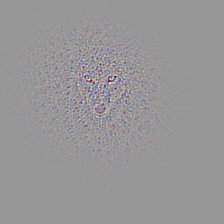

In [24]:
# -- PRESENT AND SAVE RESULTS -- #
deconv = deconv - deconv.min()
deconv *= 1.0 / (deconv.max() + K.epsilon())
uint8Deconv = (deconv * 255).astype(np.uint8)
img = pilImage.fromarray(uint8Deconv, 'RGB')
img.save('./Results/Deconv/{0}_{1}_{2}.png'.format(layerName, featVis, visMode),dpi=(250,250))
img